In [14]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid'])
mpl.rcParams["font.size"] = "12"

import torch
import torch.nn.init as init

from modules.utils import FeedForwardNetwork, plot_ode, plot_losses, rmse
from modules.problems import DampedHarmonicOscillator

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
def train(
    problem,
    model,
    alpha, beta, N_F,
    num_iters, lr,
    print_every=1000, collect_every=1000
):
    collocation_t = torch.linspace(0, problem.T, N_F, requires_grad=True).reshape(-1, 1)
    test_points = torch.linspace(0, problem.T, 128).reshape(-1, 1)
    
    losses = []
    errors = []
    
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    for i in range(0, num_iters + 1):
        
        optim.zero_grad()
        
        L_I = problem.loss_initial(model)
        L_F = problem.loss_physical(model, collocation_t)
    
        L = alpha * L_I + beta * L_F
        
        L.backward()
        optim.step()
        
        if collect_every > 0 and i % collect_every == 0:
            predicts = model(test_points).flatten().detach().numpy()
            error = rmse(predicts, problem.solution)
            errors.append(error)
            losses.append(L.item())
            
        if i % print_every == 0:
            print(f'Iteration {i} --- Loss {L.item()} --- RMSE {error}')
    
    return np.array(losses), np.array(errors)

In [ ]:
T = 10
zeta, omega = 0.2, 2.0
x_0, v_0 = 5.0, 7.0
problem = DampedHarmonicOscillator(T, (zeta, omega), (x_0, v_0))

L, W = 2, 64
model = FeedForwardNetwork(2, 64)

alpha, beta = 1.0, 0.5
N_F = 256
num_iters, lr = 10000, 1e-3

losses, errors = train(
    problem=problem,
    model=model,
    alpha=alpha, beta=beta, N_F=N_F,
    num_iters=num_iters, lr=lr,
    print_every=2500, collect_every=500
)

In [ ]:
predictions = model(problem.t.reshape(-1, 1)).detach().flatten().numpy()
plot_ode(
    problem.t.numpy(), 
    predicted=[(predictions, 'Neural Network', None)], 
    solutions=[(problem.solution, 'Numerical Solution', None)], 
    size=(5, 3)
    )

In [ ]:
plot_losses(
    t=np.arange(0, num_iters+1, 500),
    losses=[(losses, 'Loss Value')],
    errors=[(errors, 'RMSE')]
    )

## Interesting problem statements
---

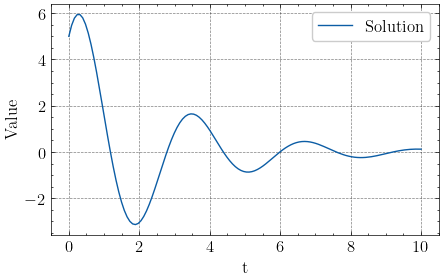

In [8]:
# Default problem. Just beautiful dynamics.
T = 10
zeta, omega = 0.2, 2.0
x_0, v_0 = 5.0, 7.0
problem = DampedHarmonicOscillator(T, (zeta, omega), (x_0, v_0))
plot_ode(problem.t.numpy(), [(problem.solution, 'Solution', None)], size=(5,3))

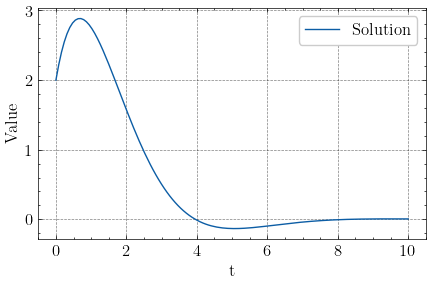

In [47]:
# When changing v_0 in this case, the solution function does not change it's 
# behavior and looks the same. Only thing that changes - magnitude of it's values

T = 10
zeta, omega = 0.7, 1.0
x_0, v_0 = 2.0, 3.0
problem = DampedHarmonicOscillator(T, (zeta, omega), (x_0, v_0))
plot_ode(problem.t.numpy(), [(problem.solution, 'Solution', None)], size=(5,3))

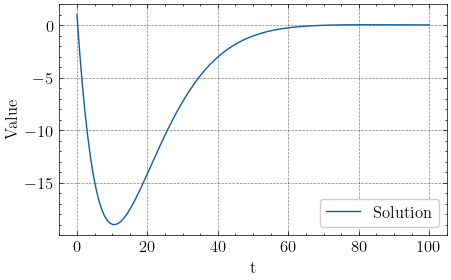

In [41]:
# This case is easy, but T is large.
T = 100
zeta, omega = 0.9, 0.1
x_0, v_0 = 1.0, -5.0
problem = DampedHarmonicOscillator(T, (zeta, omega), (x_0, v_0))
plot_ode(problem.t.numpy(), [(problem.solution, 'Solution', None)], size=(5,3))

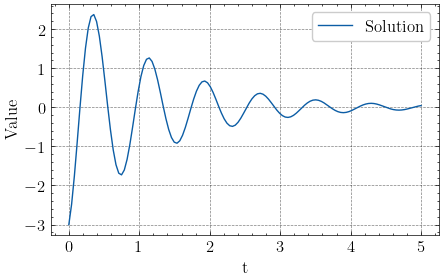

In [52]:
# This case is very dynamical. Required L, W, N_D perhaps should raise very much.
T = 5
zeta, omega = 0.1, 8
x_0, v_0 = -3.0, 10.
problem = DampedHarmonicOscillator(T, (zeta, omega), (x_0, v_0))
plot_ode(problem.t.numpy(), [(problem.solution, 'Solution', None)], size=(5,3))

In [15]:
def get_problem(N):
    match N:
        case 1:
            T = 10
            zeta, omega = 0.2, 2.0
            x_0, v_0 = 5.0, 7.0
        case 2:
            T = 10
            zeta, omega = 0.7, 1.0
            x_0, v_0 = 2.0, 3.0
        case 3:
            T = 100
            zeta, omega = 0.9, 0.1
            x_0, v_0 = 1.0, -5.0
        case 4:
            T = 5
            zeta, omega = 0.1, 8
            x_0, v_0 = -3.0, 10.
    
    problem = DampedHarmonicOscillator(T, (zeta, omega), (x_0, v_0))
    desired_rmse = rmse(np.ones(128) * problem.solution.mean(), problem.solution)
    
    return problem, desired_rmse

## Hyperparameter tuning
---

In [39]:
import optuna

def train_one_time(problem, model, N_D, coef, lr, desired_rmse):
    
    collocation_t = torch.linspace(0, problem.T, N_D, requires_grad=True).reshape(-1, 1).to(device)
    
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    predicts = model(problem.t.reshape(-1, 1).to(device)).flatten().detach().cpu().numpy()
    error = rmse(predicts, problem.solution)
    
    for i in range(10000):
        
        optim.zero_grad()
        
        L_I = problem.loss_initial(model)
        L_F = problem.loss_physical(model, collocation_t)
    
        L = coef * L_I + (1 - coef) * L_F
        
        L.backward()
        optim.step()
        
        if (i + 1) % 500 == 0:
            predicts = model(problem.t.reshape(-1, 1).to(device)).flatten().detach().cpu().numpy()
            
            new_error = rmse(predicts, problem.solution)
            if np.abs(error - new_error) < 0.01: break
            if i + 1 == 5000 and error > desired_rmse: break
            error = new_error
    
    return i + 1, error

In [ ]:
study_name = None
best_model = None
model = None

problem_number = 1
problem, desired_rmse = get_problem(problem_number)

study = optuna.create_study(study_name=f'dho_{problem_number}', direction='minimize', storage=f'sqlite:///./studies/dho_{problem_number}.db')

def objective(trial):
    
    global model
    
    L = trial.suggest_int('L', 2, 8, step=2)
    W = trial.suggest_int('W', 32, 64, step=16)
    model = FeedForwardNetwork(L, W, input_dim=1, output_dim=1).to(device)
    
    N_D = trial.suggest_int('N_D', 64, 2048, log=True)
    coef = trial.suggest_float('coef', 0.05, 0.95)
    
    lr = trial.suggest_float('lr', 1e-5, 1.0, log=True)
    
    iters, error = train_one_time(problem, model, N_D, coef, lr, desired_rmse)
    
    trial.set_user_attr("finished_iterations", iters)
    return error

def callback(study, trial):
    global best_model
    
    if study.best_trial == trial:
        best_model = model

In [ ]:
study.optimize(objective, n_trials=2, callbacks=[callback])
study.trials_dataframe().to_csv(f'./studies/{study.study_name}.csv', sep=',')
    
torch.save(best_model, f'./studies/{study.study_name}_best_model.pt')

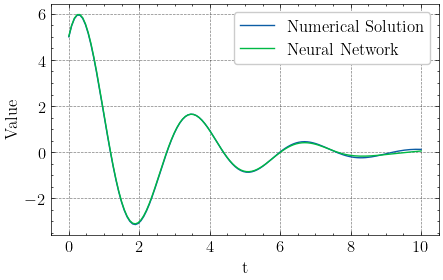

In [44]:
test_model = torch.load('./studies/dho_1_best_model.pt', map_location='cpu')

predictions = test_model(problem.t.reshape(-1, 1)).detach().flatten().cpu().numpy()
plot_ode(
    problem.t.cpu().numpy(), 
    predicted=[(predictions, 'Neural Network', None)], 
    solutions=[(problem.solution, 'Numerical Solution', None)], 
    size=(5, 3)
    )